<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multiclass-Perceptron" data-toc-modified-id="Multiclass-Perceptron-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multiclass Perceptron</a></span><ul class="toc-item"><li><span><a href="#Training-the-Model" data-toc-modified-id="Training-the-Model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Training the Model</a></span></li><li><span><a href="#Scaling-the-Input" data-toc-modified-id="Scaling-the-Input-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Scaling the Input</a></span></li></ul></li></ul></div>

# Multiclass Perceptron 
This chapter contains the multiclass perceptron implementation to classify the hand-written digits from MNIST database. 

We start with parsing the training and testing data to train and evaluate the model.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from autograd import numpy as np
from autograd import grad
from autograd.misc.flatten import flatten_func

In [2]:
# compute C linear combinations of input point, one per classifier 
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:]) 
    return a.T

# multiclass perceptron
lam = 10**-5 # our regularization paramter 
def multiclass_perceptron(w):
    # pre-compute predictions on all points
    all_evals = model(x,w)
    
    # compute maximum across data points
    a = np.max(all_evals,axis = 0)
    
    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(),np.arange(np.size(y))] 
    cost = np.sum(a - b)
    
    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:,:],'fro')**2
    
    # return average
    # print("a", a, "b", b, "cost", cost)
    return cost/float(np.size(y))

# gradient descent function 
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w] # weight history container
    cost_history = [g(w)] # cost function history container
    for k in range(max_its):
        # evaluate the gradient
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history,cost_history

def get_histories(fn, max_its, w, min_alpha=3, max_alpha=1, alpha_scale=1):
    labels = []
    cost_histories = []
    weight_histories = []
    for i in range(max_alpha, min_alpha+1):
      alpha = 10**(-i) * alpha_scale
      labels.append(r'$\alpha=10^{-%s}$' % str(i))
      weight_hist, cost_hist = gradient_descent(fn, alpha, max_its, w)
      cost_histories.append(cost_hist)
      weight_histories.append(weight_hist)
    return cost_histories, weight_histories, labels

# cost function history plotter
def plot_cost_histories(cost_histories,labels): 
    # create figure
    plt.figure() # 1, figsize=(10, 6))  
    # loop over cost histories and plot each one
    for j in range(len(cost_histories)): 
        history = cost_histories[j] 
        label = labels[j] 
        xnum = len(history)
        x = list(range(xnum))
        plt.plot(history, label = label)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def number_misclassification(y, yfit): 
    miss_count = 0
    miss_index = []
    for i in range(np.size(y)):
        if y[0][i] != yfit[i]: 
            miss_count += 1
            miss_index.append(i)
    return miss_count, miss_index

def misclassification(miss_index, y, yfit):
    for index in miss_index:
        print("y", y[0][index], "yfit", yfit[index])
        
def accuracy(miss_count, ysize): 
    return 1 - miss_count/float(ysize)

In [3]:
df_train = pd.read_csv("./traindata.csv", dtype=np.uint8)

In [4]:
df_train.head(3)

,id,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [5]:
df_train.shape

(60000, 786)

In [6]:
df_imgs = df_train.drop(['label', 'id'], axis=1)
x_original = df_imgs.as_matrix().T

In [7]:
x_original.shape

(784, 60000)

In [8]:
y_original = df_train['label'].as_matrix()

In [9]:
y_original = y_original.reshape(1, 60000)
print("y_original shape: ", y_original.shape)

y_original shape:  (1, 60000)


In [10]:
def byte_int(ubyte):
    # convert a bytes object to an int
    # return int
    return int.from_bytes(ubyte, byteorder='big', signed=False)

def read_int(file, nbyte):
    # read nbyte bytes from a file 
    # return an int
    return byte_int(file.read(nbyte))

def read_array(file, nbyte, nelement):
    # read nbyte bytes for nelement numbers from a file object
    # return a list of nelement integers 
    arr = []
    for _ in range(nelement):
        element = read_int(file, nbyte)
        arr.append(element)
    return arr

def read_labels(filename):
    # idx1 files (label files)
    with open(filename, "rb") as fdata:
        magic_number = read_int(fdata, 4)
        if magic_number != 2049:
            raise IOError("Error reading a wrong file %s with this magic number %d" 
                          % (filename, magic_number))

        nitem = read_int(fdata, 4)
        labels = read_array(fdata, 1, nitem)
    return pd.DataFrame({'label': labels}, dtype=np.uint8)


In [11]:
print("x shape:", x_original.shape)
print("y shape:", y_original.shape)
print("y size: ", np.size(y_original))
y_original.astype(int).flatten()

x shape: (784, 60000)
y shape: (1, 60000)
y size:  60000


array([5, 0, 4, ..., 5, 6, 8])

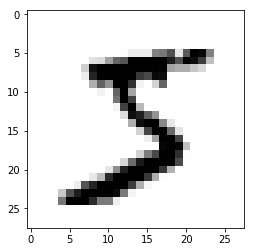

In [12]:
img0 = df_imgs.iloc[0].as_matrix()
img0 = img0.reshape((28, 28))
plt.imshow(img0, cmap='binary')

In [13]:
# sample indices
num_sample = 5000
inds = np.random.permutation(y_original.shape[1])[:num_sample]
x_sample = x_original[:,inds]
y_sample = y_original[:,inds]

## Training the Model
The code below shows the way we train the model with the parsed input, and its label.

In [16]:
x = x_original
y = y_original
yset = list(set(y[0]))

print("x shape:", x.shape)
print("y shape:", y.shape)
print("y size: ", np.size(y))

N = x.shape[0]
w_init = np.random.randn(N + 1, 1) # (785, 1)
w0 = 0.01 * np.empty((N+1, 0), dtype=float)

for _ in range(len(yset)):
    w = np.array(w_init, dtype=np.float_)
    w0 = np.append(w0, w, axis=1)
# w0 shape = (785,10)

cost_hist_arr, weight_hist, labels = get_histories(multiclass_perceptron, 1000, w0, 3, 1, 1)

x shape: (784, 60000)
y shape: (1, 60000)
y size:  60000


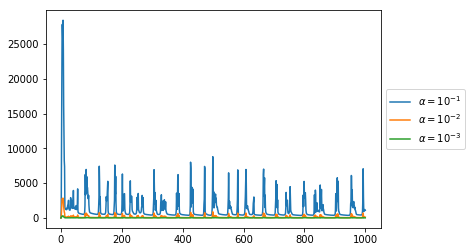

In [17]:
plot_cost_histories(cost_hist_arr, labels)

In [18]:
# choose the last weight (10**-3)
weight_opt = weight_hist[-1][-1]
yfit = model(x, weight_opt)
yfit = np.argmax(yfit, axis=0)
print(yfit.shape)
print(y.shape)

miss_count, _ = number_misclassification(y, yfit)
raw_accuracy = accuracy(miss_count, np.size(y))
print("miss_count", miss_count)
print("accuracy:", raw_accuracy)

(60000,)
(1, 60000)
miss_count 8934
accuracy: 0.8511


In [19]:
df_testdata = pd.read_csv("./testdata.csv", dtype=np.uint8)
df_testdata.head(3)

,id,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
df_testimgs = df_testdata.drop(['label', 'id'], axis=1)
xtest = df_testimgs.as_matrix().T
print("xtest shape:", xtest.shape)

xtest shape: (784, 10000)


In [21]:
ytest = df_testdata['label'].as_matrix()
ytest = ytest.reshape((10000, 1)).T
print("ytest shape:", ytest.shape)

ytest shape: (1, 10000)


In [22]:
yfit_test = model(xtest, weight_opt)
yfit_test = np.argmax(yfit_test, axis=0)
print("yfit_test shape:", yfit_test.shape)
print("yfit_test[0]:", yfit_test[0])
ytest[0][0]

miss_count, _ = number_misclassification(ytest, yfit_test)
raw_accuracy = accuracy(miss_count, np.size(ytest))
print("miss_count", miss_count)
print("accuracy:", raw_accuracy)

yfit_test shape: (10000,)
yfit_test[0]: 7
miss_count 1530
accuracy: 0.847


The accuracy of this algorithm is only 84%.

## Scaling the Input
We will attempt to scale the input, and let's see if the accuracy can be improved.

In [ ]:
xmax = np.max(x_original)

x_original_scale = x_original/xmax

In [ ]:
x = x_original_scale
y = y_original
yset = list(set(y[0]))

print("x shape:", x.shape)
print("y shape:", y.shape)
print("y size: ", np.size(y))

N = x.shape[0]
w_init = np.random.randn(N + 1, 1) # (785, 1)
w0 = 0.01 * np.empty((N+1, 0), dtype=float)

for _ in range(len(yset)):
    w = np.array(w_init, dtype=np.float_)
    w0 = np.append(w0, w, axis=1)
# w0 shape = (785,10)

cost_hist_arr, weight_hist, labels = get_histories(multiclass_perceptron, 1000, w0, 3, 1, 1)

In [ ]:
plot_cost_histories(cost_hist_arr, labels)

In [ ]:
# choose the last weight (10**-3)
weight_opt = weight_hist[-1][-1]
yfit = model(x, weight_opt)
yfit = np.argmax(yfit, axis=0)
print(yfit.shape)
print(y.shape)

miss_count, _ = number_misclassification(y, yfit)
raw_accuracy = accuracy(miss_count, np.size(y))
print("miss_count", miss_count)
print("accuracy:", raw_accuracy)